In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils
import matplotlib.pyplot as plt

In [2]:
train=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
sub=pd.read_csv('sample_submission.csv')

In [1]:
train

NameError: name 'train' is not defined

### 함수 지정

In [4]:
def range_func(x):
    max_val = np.max(x) 
    min_val = np.min(x)
    range_val = max_val - min_val #최대값 - 최소값
    return range_val

def iqr_func2(x):
    q3, q1 = np.percentile(x, [20, 80])
    iqr = q3 - q1
    return iqr # 20% - 80%

def iqr_func3(x):
    q3, q1 = np.percentile(x, [40, 60])
    iqr = q3 - q1
    return iqr # 40% - 60%

def iqr_func4(x):
    q3, q1 = np.percentile(x, [15, 95])
    iqr = q3 - q1
    return iqr # 15% - 95%

def preskew(x):
    return skew(x) #왜도

def prekurt(x):
    return kurtosis(x,fisher=True) #첨도

### 벡터값 추가

In [5]:
train['acc_vector']=np.sqrt((train['acc_x'] ** 2) +(train['acc_y'] ** 2)+(train['acc_z'] ** 2)) 
train['gy_vector']=np.sqrt((train['gy_x'] ** 2) +(train['gy_y'] ** 2)+(train['gy_z'] ** 2))

test['acc_vector']=np.sqrt((test['acc_x'] ** 2) +(test['acc_y'] ** 2)+(test['acc_z'] ** 2))
test['gy_vector']=np.sqrt((test['gy_x'] ** 2) +(test['gy_y'] ** 2)+(test['gy_z'] ** 2))

### 자이로스코프 무게중심

In [6]:
train['gy_Centerofgravity']=(train['gy_x']+train['gy_y']+train['gy_z'])/3
test['gy_Centerofgravity']=(test['gy_x']+test['gy_y']+test['gy_z'])/3

### roll, pithch (회전반경)

In [7]:
train['roll'] = np.arctan(train['acc_y']/np.sqrt(train['acc_x'] ** 2 + train['acc_z'] ** 2))
train['pitch'] = np.arctan(train['acc_x']/np.sqrt(train['acc_y'] ** 2 + train['acc_z'] ** 2))
train['gy_roll'] = np.arctan(train['gy_y']/np.sqrt(train['gy_x'] ** 2 + train['gy_z'] ** 2))
train['gy_pitch'] = np.arctan(train['gy_x']/np.sqrt(train['gy_y'] ** 2 + train['gy_z'] ** 2))

test['pitch'] = np.arctan(test['acc_x']/np.sqrt(test['acc_y'] ** 2 + test['acc_z'] ** 2))
test['roll'] = np.arctan(test['acc_y']/np.sqrt(test['acc_x'] ** 2 + test['acc_z'] ** 2))
test['gy_roll'] = np.arctan(test['gy_y']/np.sqrt(test['gy_x'] ** 2 + test['gy_z'] ** 2))
test['gy_pitch'] = np.arctan(test['gy_x']/np.sqrt(test['gy_y'] ** 2 + test['gy_z'] ** 2))

### group by mean만 하는과정

In [8]:
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z','acc_vector','gy_vector','gy_Centerofgravity']

features2 = ['id', 'roll','pitch','gy_roll','gy_pitch']

train_preprocess=train[features].groupby('id').mean().copy()
test_preprocess=test[features].groupby('id').mean().copy()

#총 변수 : 19개

#Catboost 정확도 0.72
#randomforest 정확도 0.7 시간은 3배차이

#원래는 0.8 0.79

### 함수변수 추가 후 group by

In [9]:
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z','acc_vector','gy_vector','gy_Centerofgravity']

features2 = ['id', 'roll','pitch','gy_roll','gy_pitch']

train_preprocess = train[features].groupby('id').agg(['max', 'min', 'mean','std','median',range_func,iqr_func2,iqr_func3,iqr_func4,preskew,prekurt])
temp_train_preprocess = train[features2].groupby('id').agg([range_func,iqr_func2,iqr_func3,iqr_func4,preskew,prekurt])

test_preprocess = test[features].groupby('id').agg(['max', 'min', 'mean','std','median',range_func,iqr_func2,iqr_func3,iqr_func4,preskew,prekurt])
temp_test_preprocess = test[features2].groupby('id').agg([range_func,iqr_func2,iqr_func3,iqr_func4,preskew,prekurt])

train_preprocess=pd.concat([train_preprocess,temp_train_preprocess],axis=1)
test_preprocess=pd.concat([test_preprocess,temp_test_preprocess],axis=1)

In [10]:
train_preprocess.columns=[i[0]+'_'+i[1] for i in train_preprocess.columns]
test_preprocess.columns=[i[0]+'_'+i[1] for i in test_preprocess.columns]

In [11]:
#중간점검
train_preprocess #123개

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_preskew,...,gy_roll_iqr_func3,gy_roll_iqr_func4,gy_roll_preskew,gy_roll_prekurt,gy_pitch_range_func,gy_pitch_iqr_func2,gy_pitch_iqr_func3,gy_pitch_iqr_func4,gy_pitch_preskew,gy_pitch_prekurt
id,,,,,,,,,,,,,,,,,,,,,
0,1.344268,0.591940,0.931329,0.191479,0.956149,0.752327,-0.369662,-0.172673,-0.544985,0.106076,...,-0.490935,-1.791598,0.094874,-1.064726,2.977117,-0.982953,-0.247226,-1.925501,0.128560,-0.143170
1,1.234020,-2.156208,-0.766580,0.495528,-0.805767,3.390228,-0.892320,-0.259957,-1.126772,-0.202959,...,-0.379454,-1.989773,-0.150883,-0.683533,2.866306,-1.475187,-0.395792,-1.982914,-0.100541,-1.006218
2,1.219836,-1.142847,0.039836,0.711972,0.140667,2.362683,-1.561197,-0.761086,-1.807555,-0.180743,...,-1.682675,-2.920526,-0.273810,-1.780833,2.681002,-0.387218,-0.109436,-0.757699,-0.271634,2.876820
3,-0.622250,-1.417751,-0.887702,0.130899,-0.880343,0.795502,-0.227442,-0.070906,-0.332513,-0.606239,...,-0.400124,-1.920756,-0.098449,-0.924364,3.082571,-1.637564,-0.574426,-2.065111,-0.242322,-1.142099
4,0.599720,-2.429109,-0.659018,0.495170,-0.941146,3.028829,-0.724182,-0.337496,-1.314271,0.491559,...,-0.316218,-1.504008,-0.123451,-0.470192,3.099170,-1.563356,-0.461233,-2.327640,0.334137,-0.963076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,0.390798,-1.624711,-0.300454,0.403175,-0.105704,2.015509,-0.734687,-0.024370,-1.151625,-0.922420,...,-0.285880,-1.665726,-0.514503,-0.568216,2.979482,-1.333628,-0.434936,-2.016105,0.221518,-0.759062
3121,-0.446650,-1.575455,-0.974298,0.169963,-0.980053,1.128804,-0.202045,-0.015255,-0.452615,-0.111515,...,-0.203518,-1.241979,-0.612739,0.414541,3.012128,-1.997647,-0.955271,-2.331223,-0.077648,-1.498409
3122,0.744666,-2.578974,-1.114246,0.683789,-1.057063,3.323641,-1.396306,-0.486834,-1.845096,-0.110431,...,-1.345177,-2.339231,-0.060028,-1.725392,2.978832,-0.904839,-0.364287,-1.186526,-0.085146,-0.488642


### 운동시작지점과 가속도계, 자이로스코프의 첫 3초의 평균

In [12]:
# 가속도계 첫번째 데이터 -> 운동시작지점
train_acc_head1=pd.DataFrame()
for i in train['id'].unique():
    train_acc_head1=train_acc_head1.append(train[['id','acc_x','acc_y','acc_z']][train[['id','acc_x','acc_y','acc_z']]['id']==i].head(1))
train_acc_head1.columns=['id','first_acc_x','first_acc_y','first_acc_z']
train_acc_head1.set_index('id',inplace=True)

test_acc_head1=pd.DataFrame()
for i in test['id'].unique():
    test_acc_head1=test_acc_head1.append(test[['id','acc_x','acc_y','acc_z']][test[['id','acc_x','acc_y','acc_z']]['id']==i].head(1))
test_acc_head1.columns=['id','first_acc_x','first_acc_y','first_acc_z']
test_acc_head1.set_index('id',inplace=True)

# 가속도계 첫 3초 -> 초반에 급격하게 움직이는 운동과 정적인 운동을 비교
train_acc_head=pd.DataFrame()
for i in train['id'].unique():
    train_acc_head=train_acc_head.append(train[['id','acc_x','acc_y','acc_z']][train[['id','acc_x','acc_y','acc_z']]['id']==i].head(150))
train_acc_head.columns=['id','head_acc_x','head_acc_y','head_acc_z'] #총 600개니까 150개
train_acc_head=train_acc_head.groupby('id').mean() #첫 3초의 가속도 평균

test_acc_head=pd.DataFrame()
for i in test['id'].unique():
    test_acc_head=test_acc_head.append(test[['id','acc_x','acc_y','acc_z']][test[['id','acc_x','acc_y','acc_z']]['id']==i].head(150))
test_acc_head.columns=['id','head_acc_x','head_acc_y','head_acc_z']
test_acc_head=test_acc_head.groupby('id').mean()

train_preprocess=pd.concat([train_preprocess,train_acc_head,train_acc_head1],axis=1)
test_preprocess=pd.concat([test_preprocess,test_acc_head,test_acc_head1],axis=1)

# 자이로스코프 첫 3초
train_gy_head=pd.DataFrame()
for i in train['id'].unique():
    train_gy_head=train_gy_head.append(train[['id','gy_x','gy_y','gy_z']][train[['id','gy_x','gy_y','gy_z']]['id']==i].head(150))
train_gy_head.columns=['id','head_gy_x','head_gy_y','head_gy_z']
train_gy_head=train_gy_head.groupby('id').mean()

test_gy_head=pd.DataFrame()
for i in test['id'].unique():
    test_gy_head=test_gy_head.append(test[['id','gy_x','gy_y','gy_z']][test[['id','gy_x','gy_y','gy_z']]['id']==i].head(150))
test_gy_head.columns=['id','head_gy_x','head_gy_y','head_gy_z']
test_gy_head=test_gy_head.groupby('id').mean()

train_preprocess=pd.concat([train_preprocess,train_gy_head],axis=1)
test_preprocess=pd.concat([test_preprocess,test_gy_head],axis=1)

### Kmeans

In [13]:
model = KMeans(n_clusters=5,random_state=20)
model.fit(train_preprocess)

train_predict = model.predict(train_preprocess)
train_preprocess['cluster']=train_predict

test_predict = model.predict(test_preprocess)
test_preprocess['cluster']=test_predict

In [14]:
#중간점검
train_preprocess #133개

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_preskew,...,head_acc_x,head_acc_y,head_acc_z,first_acc_x,first_acc_y,first_acc_z,head_gy_x,head_gy_y,head_gy_z,cluster
id,,,,,,,,,,,,,,,,,,,,,
0,1.344268,0.591940,0.931329,0.191479,0.956149,0.752327,-0.369662,-0.172673,-0.544985,0.106076,...,0.930401,-0.204424,-0.357682,1.206087,-0.179371,-0.148447,-2.033206,-7.620945,-1.012112,0
1,1.234020,-2.156208,-0.766580,0.495528,-0.805767,3.390228,-0.892320,-0.259957,-1.126772,-0.202959,...,-0.313634,-0.567014,0.471395,-0.211795,-0.078760,0.854627,-26.182937,8.268198,10.465675,2
2,1.219836,-1.142847,0.039836,0.711972,0.140667,2.362683,-1.561197,-0.761086,-1.807555,-0.180743,...,0.005221,-0.113100,0.600223,0.241388,-0.437876,0.797198,-4.955283,-8.169446,2.694235,4
3,-0.622250,-1.417751,-0.887702,0.130899,-0.880343,0.795502,-0.227442,-0.070906,-0.332513,-0.606239,...,-0.912448,-0.256042,0.108072,-1.066225,-0.280265,0.003342,17.512190,2.476961,-0.595546,4
4,0.599720,-2.429109,-0.659018,0.495170,-0.941146,3.028829,-0.724182,-0.337496,-1.314271,0.491559,...,0.014436,-0.902046,0.173936,0.144852,-1.331613,-1.231836,-20.248809,32.095738,15.112848,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,0.390798,-1.624711,-0.300454,0.403175,-0.105704,2.015509,-0.734687,-0.024370,-1.151625,-0.922420,...,-0.055424,-0.760497,0.320807,0.095092,-0.827868,0.542625,-22.442501,-16.061831,13.936728,4
3121,-0.446650,-1.575455,-0.974298,0.169963,-0.980053,1.128804,-0.202045,-0.015255,-0.452615,-0.111515,...,-1.017820,-0.184831,-0.114710,-0.588936,-0.131407,-0.077380,42.917552,12.480624,-6.834904,0
3122,0.744666,-2.578974,-1.114246,0.683789,-1.057063,3.323641,-1.396306,-0.486834,-1.845096,-0.110431,...,-1.046002,-0.490153,0.235311,-1.327998,-0.385354,0.379149,11.134857,29.792051,-1.994560,1


# 전처리 끝

In [15]:
train_preprocess.head(3)

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_preskew,...,head_acc_x,head_acc_y,head_acc_z,first_acc_x,first_acc_y,first_acc_z,head_gy_x,head_gy_y,head_gy_z,cluster
id,,,,,,,,,,,,,,,,,,,,,
0,1.344268,0.591940,0.931329,0.191479,0.956149,0.752327,-0.369662,-0.172673,-0.544985,0.106076,...,0.930401,-0.204424,-0.357682,1.206087,-0.179371,-0.148447,-2.033206,-7.620945,-1.012112,0
1,1.234020,-2.156208,-0.766580,0.495528,-0.805767,3.390228,-0.892320,-0.259957,-1.126772,-0.202959,...,-0.313634,-0.567014,0.471395,-0.211795,-0.078760,0.854627,-26.182937,8.268198,10.465675,2
2,1.219836,-1.142847,0.039836,0.711972,0.140667,2.362683,-1.561197,-0.761086,-1.807555,-0.180743,...,0.005221,-0.113100,0.600223,0.241388,-0.437876,0.797198,-4.955283,-8.169446,2.694235,4


In [16]:
train.head(3)

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_vector,gy_vector,gy_Centerofgravity,roll,pitch,gy_roll,gy_pitch
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.228355,44.010999,-20.938910,-0.146550,1.380095,-0.767200,-0.013443
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.315689,46.403958,-21.254406,-0.151814,1.364146,-1.003661,0.006532
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.343234,50.851423,-24.253157,-0.145773,1.330405,-1.050508,-0.071194


In [17]:
train_data = train.iloc[:,2:].copy()
train_s = []

for i in range(int(len(train_data)/600)):
    train_s.append(train_data[(i*600):((i+1)*600)])
    
train_arr = [np.array(i) for i in train_s]
train_arr_3d = np.array(train_arr)

In [18]:
test_data = test.iloc[:,2:].copy()
test_s = []
for i in range(int(len(test_data)/600)):
    test_s.append(test_data[(i*600):((i+1)*600)])

test_arr = [np.array(i) for i in test_s]
test_arr_3d = np.array(test_arr)

In [19]:
print(train_arr_3d.shape)
print(test_arr_3d.shape)
print(train_labels.shape)

(3125, 600, 13)
(782, 600, 13)
(3125, 3)


 **Label별로 8:2 분리**

In [20]:
y1a = []
y2a = []
for i in list(set(train_labels['label'])):
    train_sample = train_labels[train_labels['label']==i]
    y1_a, y2_a = train_test_split(train_sample, test_size = 0.2, random_state = 0)
    y1a.append(y1_a)
    y2a.append(y2_a)

In [21]:
#데이터 병합
label_split1 = pd.concat(y1a, ignore_index=True)
label_split2 = pd.concat(y2a, ignore_index=True)

In [22]:
train_preprocess['id'] = train_preprocess.index

In [23]:
x1_list = []
for i in list(label_split1['id']):
    x1_list.append(train_preprocess[train_preprocess['id']==i])
x_label_split1 = pd.concat(x1_list, ignore_index=True)
x_label_split1

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_preskew,...,head_acc_y,head_acc_z,first_acc_x,first_acc_y,first_acc_z,head_gy_x,head_gy_y,head_gy_z,cluster,id
0,0.092785,-1.645166,-0.976842,0.130423,-0.983786,1.737951,-0.156382,-0.046232,-0.309685,1.319957,...,-0.219339,0.000613,-0.905257,-0.159684,-0.092279,-8.092016,2.018502,1.095581,2,2949
1,1.042597,-0.730070,0.581954,0.406400,0.752907,1.772667,-0.721442,-0.219244,-0.959281,-1.082580,...,-0.756375,-0.020566,0.093728,-1.045018,-0.522034,42.440981,-15.302716,9.351537,2,181
2,0.859523,-0.180085,0.182304,0.222637,0.153396,1.039608,-0.346505,-0.081290,-0.769536,1.076648,...,-0.102560,-0.919434,0.345104,0.103736,-1.009085,7.026716,21.876152,6.978492,4,2519
3,0.268830,-1.438653,-0.493252,0.407463,-0.366171,1.707483,-0.823693,-0.190001,-1.071134,-0.463178,...,1.021526,-0.167005,-0.044338,0.878467,-0.432384,-11.427680,-6.543644,0.759502,4,141
4,0.591323,-0.561377,0.037189,0.197012,0.008934,1.152700,-0.331201,-0.098990,-0.538394,0.240855,...,-0.851764,-0.553684,0.094824,-0.901397,-0.543325,-5.296219,-11.835446,-5.194099,4,2517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,-0.109847,-0.914596,-0.531165,0.051952,-0.533861,0.804749,-0.026199,-0.008363,-0.051898,1.458853,...,-0.554532,0.559385,-0.551418,-0.589693,0.548402,-1.657034,-2.875014,2.543859,0,2612
2478,-0.881614,-1.324807,-0.985787,0.025134,-0.984078,0.443192,-0.017886,-0.005521,-0.031833,-6.792072,...,-0.211603,0.097936,-1.324807,-0.242662,0.130807,-13.673862,-1.236592,2.499926,0,3086
2479,-0.903366,-1.010150,-0.956342,0.011619,-0.955423,0.106784,-0.016270,-0.005010,-0.025660,-0.565128,...,-0.322576,0.044208,-0.978571,-0.260208,0.135447,-13.510092,-1.831564,1.845382,0,376
2480,0.800926,-0.876001,-0.515558,0.253721,-0.579892,1.676927,-0.087670,-0.018508,-0.758023,3.391536,...,0.858547,-0.430263,-0.255195,0.971977,-0.389371,-1.240713,1.668917,-4.222234,2,21


In [24]:
x2_list = []
for i in list(label_split2['id']):
    x2_list.append(train_preprocess[train_preprocess['id']==i])
x_label_split2 = pd.concat(x2_list, ignore_index=True)
x_label_split2

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_preskew,...,head_acc_y,head_acc_z,first_acc_x,first_acc_y,first_acc_z,head_gy_x,head_gy_y,head_gy_z,cluster,id
0,0.581214,-2.114807,-0.048037,0.261168,-0.035663,2.696021,-0.283003,-0.074221,-0.507428,-3.236546,...,0.839507,0.405866,-0.042123,1.010202,0.194034,-14.786326,2.575664,-1.795262,4,2324
1,0.602739,-1.132215,-0.308196,0.342429,-0.243300,1.734954,-0.658023,-0.161061,-0.977307,-0.181465,...,0.861056,-0.467633,0.195820,0.774690,-0.768031,-12.990767,-29.829161,-23.245861,2,3101
2,0.830356,-1.615534,-0.623359,0.508168,-0.813493,2.445891,-0.748123,-0.124726,-1.501581,1.168261,...,-0.171010,0.265232,-0.415035,-0.716281,0.144635,19.107630,5.390601,-3.771936,4,1628
3,1.397978,0.090319,0.795427,0.240989,0.852573,1.307659,-0.420101,-0.108143,-0.597509,-0.584816,...,-0.532958,0.243177,1.049708,-0.581824,0.538764,-9.180166,2.839218,3.499812,0,1396
4,1.375286,-0.219618,0.533974,0.247129,0.509541,1.594904,-0.368148,-0.091306,-0.719782,0.384804,...,-0.703723,0.352238,0.127626,-0.681293,-0.146255,-3.075611,2.748088,7.650101,4,1655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,-0.591718,-1.191744,-0.885487,0.057381,-0.874341,0.600026,-0.029212,-0.007550,-0.065043,-1.608762,...,-0.562631,0.019249,-0.804843,-0.620413,0.051580,-2.791172,-0.743079,0.418262,0,2485
639,0.933109,-0.982953,-0.271803,0.372438,-0.317054,1.916062,-0.609152,-0.326970,-1.244291,1.097586,...,-0.791857,0.483138,-0.148228,-0.939919,0.588416,6.119638,-7.682740,5.162984,4,2241
640,-0.022359,-1.187387,-0.535381,0.088787,-0.558108,1.165028,-0.056783,-0.012201,-0.230141,0.876533,...,-0.768427,0.319206,-0.343072,-0.845649,0.376773,4.160937,0.560363,2.629283,0,2734
641,0.527282,-1.122572,0.284448,0.375569,0.449793,1.649854,-0.199139,-0.020066,-0.483703,-2.033256,...,-0.715284,0.375157,-0.793490,-0.832156,0.201017,20.444847,-18.880131,-3.922348,4,925


In [25]:
train_preprocess = train_preprocess.drop('id',1)
x_label_split1 = x_label_split1.drop('id',1)
x_label_split2 = x_label_split2.drop('id',1)

In [26]:
y_label_split1 = label_split1['label']
y_label_split2 = label_split2['label']

In [27]:
print(train_preprocess.shape)
print(test_preprocess.shape)
print(x_label_split1.shape)
print(x_label_split2.shape)
print(y_label_split1.shape)
print(y_label_split2.shape)
print(train_arr_3d.shape)
print(test_arr_3d.shape)
print(train_labels.shape)
print(label_split1.shape)
print(label_split2.shape)

(3125, 133)
(782, 133)
(2482, 133)
(643, 133)
(2482,)
(643,)
(3125, 600, 13)
(782, 600, 13)
(3125, 3)
(2482, 3)
(643, 3)


In [28]:
#멈춰!!

# catboost

In [29]:
x_train, x_test, y_train, y_test = train_test_split(train_preprocess,train_labels['label'], test_size=0.2, random_state=42)

In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2500, 133)
(2500,)
(625, 133)
(625,)


In [31]:
cat_train=CatBoostClassifier(random_state=20,iterations=1000,depth=3)
cat_train.fit(x_train,y_train)

Learning rate set to 0.082912
0:	learn: 2.7162144	total: 272ms	remaining: 4m 31s
1:	learn: 2.6192378	total: 378ms	remaining: 3m 8s
2:	learn: 2.5406664	total: 467ms	remaining: 2m 35s
3:	learn: 2.4714011	total: 558ms	remaining: 2m 18s
4:	learn: 2.3933911	total: 644ms	remaining: 2m 8s
5:	learn: 2.3438963	total: 732ms	remaining: 2m 1s
6:	learn: 2.2928808	total: 824ms	remaining: 1m 56s
7:	learn: 2.2512410	total: 915ms	remaining: 1m 53s
8:	learn: 2.2071362	total: 1.01s	remaining: 1m 51s
9:	learn: 2.1801295	total: 1.1s	remaining: 1m 48s
10:	learn: 2.1315112	total: 1.21s	remaining: 1m 48s
11:	learn: 2.1033837	total: 1.3s	remaining: 1m 46s
12:	learn: 2.0504270	total: 1.39s	remaining: 1m 45s
13:	learn: 2.0226435	total: 1.48s	remaining: 1m 44s
14:	learn: 1.9970668	total: 1.57s	remaining: 1m 43s
15:	learn: 1.9733094	total: 1.66s	remaining: 1m 42s
16:	learn: 1.9359789	total: 1.75s	remaining: 1m 41s
17:	learn: 1.9119747	total: 1.84s	remaining: 1m 40s
18:	learn: 1.8946178	total: 1.93s	remaining: 1m 3

159:	learn: 0.7537275	total: 14.8s	remaining: 1m 17s
160:	learn: 0.7518680	total: 14.8s	remaining: 1m 17s
161:	learn: 0.7487262	total: 14.9s	remaining: 1m 17s
162:	learn: 0.7460030	total: 15s	remaining: 1m 17s
163:	learn: 0.7414660	total: 15.1s	remaining: 1m 16s
164:	learn: 0.7391132	total: 15.2s	remaining: 1m 16s
165:	learn: 0.7377685	total: 15.3s	remaining: 1m 16s
166:	learn: 0.7361860	total: 15.4s	remaining: 1m 16s
167:	learn: 0.7338366	total: 15.5s	remaining: 1m 16s
168:	learn: 0.7322112	total: 15.5s	remaining: 1m 16s
169:	learn: 0.7295639	total: 15.6s	remaining: 1m 16s
170:	learn: 0.7276381	total: 15.7s	remaining: 1m 16s
171:	learn: 0.7253830	total: 15.8s	remaining: 1m 16s
172:	learn: 0.7241721	total: 15.9s	remaining: 1m 15s
173:	learn: 0.7218096	total: 16s	remaining: 1m 15s
174:	learn: 0.7189065	total: 16.1s	remaining: 1m 15s
175:	learn: 0.7172198	total: 16.1s	remaining: 1m 15s
176:	learn: 0.7141914	total: 16.2s	remaining: 1m 15s
177:	learn: 0.7126052	total: 16.3s	remaining: 1m 1

318:	learn: 0.5009238	total: 28.8s	remaining: 1m 1s
319:	learn: 0.4998608	total: 28.9s	remaining: 1m 1s
320:	learn: 0.4991590	total: 29s	remaining: 1m 1s
321:	learn: 0.4986117	total: 29.1s	remaining: 1m 1s
322:	learn: 0.4977003	total: 29.2s	remaining: 1m 1s
323:	learn: 0.4965285	total: 29.3s	remaining: 1m 1s
324:	learn: 0.4956669	total: 29.3s	remaining: 1m
325:	learn: 0.4954077	total: 29.4s	remaining: 1m
326:	learn: 0.4950463	total: 29.5s	remaining: 1m
327:	learn: 0.4949784	total: 29.6s	remaining: 1m
328:	learn: 0.4941703	total: 29.7s	remaining: 1m
329:	learn: 0.4929240	total: 29.8s	remaining: 1m
330:	learn: 0.4921583	total: 29.9s	remaining: 1m
331:	learn: 0.4913549	total: 29.9s	remaining: 1m
332:	learn: 0.4902899	total: 30s	remaining: 1m
333:	learn: 0.4896123	total: 30.1s	remaining: 1m
334:	learn: 0.4885216	total: 30.2s	remaining: 60s
335:	learn: 0.4877417	total: 30.3s	remaining: 59.9s
336:	learn: 0.4867445	total: 30.4s	remaining: 59.8s
337:	learn: 0.4857463	total: 30.5s	remaining: 59

480:	learn: 0.3848882	total: 43.1s	remaining: 46.5s
481:	learn: 0.3847428	total: 43.2s	remaining: 46.4s
482:	learn: 0.3841146	total: 43.2s	remaining: 46.3s
483:	learn: 0.3831816	total: 43.3s	remaining: 46.2s
484:	learn: 0.3826043	total: 43.4s	remaining: 46.1s
485:	learn: 0.3814503	total: 43.5s	remaining: 46s
486:	learn: 0.3805267	total: 43.6s	remaining: 45.9s
487:	learn: 0.3799483	total: 43.7s	remaining: 45.8s
488:	learn: 0.3790963	total: 43.8s	remaining: 45.8s
489:	learn: 0.3786106	total: 43.9s	remaining: 45.7s
490:	learn: 0.3773939	total: 44s	remaining: 45.6s
491:	learn: 0.3769902	total: 44.1s	remaining: 45.5s
492:	learn: 0.3766129	total: 44.1s	remaining: 45.4s
493:	learn: 0.3758477	total: 44.2s	remaining: 45.3s
494:	learn: 0.3753414	total: 44.3s	remaining: 45.2s
495:	learn: 0.3746900	total: 44.4s	remaining: 45.1s
496:	learn: 0.3737129	total: 44.5s	remaining: 45s
497:	learn: 0.3729754	total: 44.6s	remaining: 44.9s
498:	learn: 0.3723535	total: 44.7s	remaining: 44.9s
499:	learn: 0.3716

639:	learn: 0.3034290	total: 57.2s	remaining: 32.2s
640:	learn: 0.3029545	total: 57.3s	remaining: 32.1s
641:	learn: 0.3027171	total: 57.4s	remaining: 32s
642:	learn: 0.3023395	total: 57.4s	remaining: 31.9s
643:	learn: 0.3018733	total: 57.5s	remaining: 31.8s
644:	learn: 0.3014317	total: 57.6s	remaining: 31.7s
645:	learn: 0.3008440	total: 57.7s	remaining: 31.6s
646:	learn: 0.3005025	total: 57.8s	remaining: 31.5s
647:	learn: 0.3004504	total: 57.9s	remaining: 31.4s
648:	learn: 0.2999581	total: 58s	remaining: 31.3s
649:	learn: 0.2997890	total: 58s	remaining: 31.3s
650:	learn: 0.2995437	total: 58.1s	remaining: 31.2s
651:	learn: 0.2991633	total: 58.2s	remaining: 31.1s
652:	learn: 0.2990022	total: 58.3s	remaining: 31s
653:	learn: 0.2986667	total: 58.4s	remaining: 30.9s
654:	learn: 0.2983374	total: 58.5s	remaining: 30.8s
655:	learn: 0.2978609	total: 58.6s	remaining: 30.7s
656:	learn: 0.2970065	total: 58.6s	remaining: 30.6s
657:	learn: 0.2966785	total: 58.7s	remaining: 30.5s
658:	learn: 0.296051

798:	learn: 0.2476179	total: 1m 11s	remaining: 17.9s
799:	learn: 0.2474265	total: 1m 11s	remaining: 17.8s
800:	learn: 0.2471829	total: 1m 11s	remaining: 17.8s
801:	learn: 0.2469337	total: 1m 11s	remaining: 17.7s
802:	learn: 0.2467603	total: 1m 11s	remaining: 17.6s
803:	learn: 0.2462331	total: 1m 11s	remaining: 17.5s
804:	learn: 0.2459974	total: 1m 11s	remaining: 17.4s
805:	learn: 0.2457093	total: 1m 11s	remaining: 17.3s
806:	learn: 0.2451103	total: 1m 12s	remaining: 17.2s
807:	learn: 0.2446375	total: 1m 12s	remaining: 17.1s
808:	learn: 0.2443230	total: 1m 12s	remaining: 17s
809:	learn: 0.2440922	total: 1m 12s	remaining: 17s
810:	learn: 0.2438066	total: 1m 12s	remaining: 16.9s
811:	learn: 0.2435437	total: 1m 12s	remaining: 16.8s
812:	learn: 0.2433782	total: 1m 12s	remaining: 16.7s
813:	learn: 0.2430666	total: 1m 12s	remaining: 16.6s
814:	learn: 0.2427901	total: 1m 12s	remaining: 16.5s
815:	learn: 0.2424021	total: 1m 12s	remaining: 16.4s
816:	learn: 0.2420798	total: 1m 12s	remaining: 16.

956:	learn: 0.2037501	total: 1m 25s	remaining: 3.86s
957:	learn: 0.2035680	total: 1m 25s	remaining: 3.77s
958:	learn: 0.2033187	total: 1m 26s	remaining: 3.68s
959:	learn: 0.2030392	total: 1m 26s	remaining: 3.59s
960:	learn: 0.2028724	total: 1m 26s	remaining: 3.5s
961:	learn: 0.2026677	total: 1m 26s	remaining: 3.41s
962:	learn: 0.2024062	total: 1m 26s	remaining: 3.32s
963:	learn: 0.2020595	total: 1m 26s	remaining: 3.23s
964:	learn: 0.2017707	total: 1m 26s	remaining: 3.14s
965:	learn: 0.2015523	total: 1m 26s	remaining: 3.05s
966:	learn: 0.2013073	total: 1m 26s	remaining: 2.96s
967:	learn: 0.2010946	total: 1m 26s	remaining: 2.87s
968:	learn: 0.2009056	total: 1m 26s	remaining: 2.78s
969:	learn: 0.2007883	total: 1m 27s	remaining: 2.69s
970:	learn: 0.2006829	total: 1m 27s	remaining: 2.6s
971:	learn: 0.2003944	total: 1m 27s	remaining: 2.51s
972:	learn: 0.2001189	total: 1m 27s	remaining: 2.42s
973:	learn: 0.1998565	total: 1m 27s	remaining: 2.33s
974:	learn: 0.1997273	total: 1m 27s	remaining: 2

In [32]:
cat_train=CatBoostClassifier()
cat_train.fit(x_train,y_train)

Learning rate set to 0.082912
0:	learn: 3.0027214	total: 903ms	remaining: 15m 1s
1:	learn: 2.8337418	total: 1.79s	remaining: 14m 53s
2:	learn: 2.6934521	total: 2.65s	remaining: 14m 41s
3:	learn: 2.5735220	total: 3.52s	remaining: 14m 35s
4:	learn: 2.4745577	total: 4.39s	remaining: 14m 33s
5:	learn: 2.3916286	total: 5.27s	remaining: 14m 33s
6:	learn: 2.3014301	total: 6.23s	remaining: 14m 43s
7:	learn: 2.2182769	total: 7.1s	remaining: 14m 40s
8:	learn: 2.1478360	total: 7.95s	remaining: 14m 35s
9:	learn: 2.0862726	total: 8.87s	remaining: 14m 37s
10:	learn: 2.0254075	total: 9.73s	remaining: 14m 35s
11:	learn: 1.9770400	total: 10.7s	remaining: 14m 37s
12:	learn: 1.9269359	total: 11.5s	remaining: 14m 34s
13:	learn: 1.8815057	total: 12.4s	remaining: 14m 34s
14:	learn: 1.8345791	total: 13.3s	remaining: 14m 33s
15:	learn: 1.7835147	total: 14.2s	remaining: 14m 32s
16:	learn: 1.7410485	total: 15.1s	remaining: 14m 30s
17:	learn: 1.7052900	total: 16s	remaining: 14m 30s
18:	learn: 1.6640890	total: 16

153:	learn: 0.4585982	total: 2m 14s	remaining: 12m 19s
154:	learn: 0.4555460	total: 2m 15s	remaining: 12m 18s
155:	learn: 0.4528227	total: 2m 16s	remaining: 12m 17s
156:	learn: 0.4497329	total: 2m 17s	remaining: 12m 16s
157:	learn: 0.4475267	total: 2m 18s	remaining: 12m 15s
158:	learn: 0.4458152	total: 2m 18s	remaining: 12m 14s
159:	learn: 0.4430304	total: 2m 19s	remaining: 12m 13s
160:	learn: 0.4408192	total: 2m 20s	remaining: 12m 11s
161:	learn: 0.4385692	total: 2m 21s	remaining: 12m 10s
162:	learn: 0.4360295	total: 2m 22s	remaining: 12m 9s
163:	learn: 0.4339741	total: 2m 22s	remaining: 12m 8s
164:	learn: 0.4313916	total: 2m 23s	remaining: 12m 7s
165:	learn: 0.4298035	total: 2m 24s	remaining: 12m 6s
166:	learn: 0.4278990	total: 2m 25s	remaining: 12m 5s
167:	learn: 0.4250952	total: 2m 26s	remaining: 12m 4s
168:	learn: 0.4218139	total: 2m 27s	remaining: 12m 3s
169:	learn: 0.4195583	total: 2m 27s	remaining: 12m 1s
170:	learn: 0.4168755	total: 2m 28s	remaining: 12m
171:	learn: 0.4144888	

304:	learn: 0.2390600	total: 4m 19s	remaining: 9m 52s
305:	learn: 0.2380397	total: 4m 20s	remaining: 9m 51s
306:	learn: 0.2372724	total: 4m 21s	remaining: 9m 50s
307:	learn: 0.2366712	total: 4m 22s	remaining: 9m 49s
308:	learn: 0.2360014	total: 4m 23s	remaining: 9m 48s
309:	learn: 0.2354033	total: 4m 23s	remaining: 9m 47s
310:	learn: 0.2343647	total: 4m 24s	remaining: 9m 46s
311:	learn: 0.2334366	total: 4m 25s	remaining: 9m 45s
312:	learn: 0.2325346	total: 4m 26s	remaining: 9m 44s
313:	learn: 0.2320358	total: 4m 27s	remaining: 9m 43s
314:	learn: 0.2314216	total: 4m 28s	remaining: 9m 43s
315:	learn: 0.2306011	total: 4m 28s	remaining: 9m 42s
316:	learn: 0.2292352	total: 4m 29s	remaining: 9m 41s
317:	learn: 0.2281666	total: 4m 30s	remaining: 9m 40s
318:	learn: 0.2274251	total: 4m 31s	remaining: 9m 39s
319:	learn: 0.2269373	total: 4m 32s	remaining: 9m 38s
320:	learn: 0.2261384	total: 4m 33s	remaining: 9m 37s
321:	learn: 0.2254539	total: 4m 34s	remaining: 9m 36s
322:	learn: 0.2246406	total:

457:	learn: 0.1483182	total: 6m 27s	remaining: 7m 38s
458:	learn: 0.1479308	total: 6m 28s	remaining: 7m 37s
459:	learn: 0.1476933	total: 6m 29s	remaining: 7m 36s
460:	learn: 0.1472198	total: 6m 30s	remaining: 7m 36s
461:	learn: 0.1470303	total: 6m 30s	remaining: 7m 35s
462:	learn: 0.1466202	total: 6m 31s	remaining: 7m 34s
463:	learn: 0.1465065	total: 6m 32s	remaining: 7m 33s
464:	learn: 0.1462209	total: 6m 33s	remaining: 7m 32s
465:	learn: 0.1460350	total: 6m 34s	remaining: 7m 31s
466:	learn: 0.1452808	total: 6m 35s	remaining: 7m 30s
467:	learn: 0.1449985	total: 6m 35s	remaining: 7m 30s
468:	learn: 0.1446182	total: 6m 36s	remaining: 7m 29s
469:	learn: 0.1442475	total: 6m 37s	remaining: 7m 28s
470:	learn: 0.1440956	total: 6m 38s	remaining: 7m 27s
471:	learn: 0.1435570	total: 6m 39s	remaining: 7m 26s
472:	learn: 0.1432607	total: 6m 40s	remaining: 7m 25s
473:	learn: 0.1428385	total: 6m 40s	remaining: 7m 24s
474:	learn: 0.1423254	total: 6m 41s	remaining: 7m 23s
475:	learn: 0.1418753	total:

610:	learn: 0.0989758	total: 8m 34s	remaining: 5m 27s
611:	learn: 0.0987490	total: 8m 35s	remaining: 5m 26s
612:	learn: 0.0984584	total: 8m 35s	remaining: 5m 25s
613:	learn: 0.0982043	total: 8m 36s	remaining: 5m 24s
614:	learn: 0.0979980	total: 8m 37s	remaining: 5m 24s
615:	learn: 0.0977136	total: 8m 38s	remaining: 5m 23s
616:	learn: 0.0974745	total: 8m 39s	remaining: 5m 22s
617:	learn: 0.0972066	total: 8m 40s	remaining: 5m 21s
618:	learn: 0.0970346	total: 8m 40s	remaining: 5m 20s
619:	learn: 0.0968312	total: 8m 41s	remaining: 5m 19s
620:	learn: 0.0966627	total: 8m 42s	remaining: 5m 18s
621:	learn: 0.0965168	total: 8m 43s	remaining: 5m 18s
622:	learn: 0.0962715	total: 8m 44s	remaining: 5m 17s
623:	learn: 0.0959775	total: 8m 45s	remaining: 5m 16s
624:	learn: 0.0957164	total: 8m 45s	remaining: 5m 15s
625:	learn: 0.0954137	total: 8m 46s	remaining: 5m 14s
626:	learn: 0.0950536	total: 8m 47s	remaining: 5m 13s
627:	learn: 0.0948526	total: 8m 48s	remaining: 5m 13s
628:	learn: 0.0947693	total:

762:	learn: 0.0717008	total: 10m 41s	remaining: 3m 19s
763:	learn: 0.0715435	total: 10m 41s	remaining: 3m 18s
764:	learn: 0.0713937	total: 10m 42s	remaining: 3m 17s
765:	learn: 0.0712436	total: 10m 43s	remaining: 3m 16s
766:	learn: 0.0711288	total: 10m 44s	remaining: 3m 15s
767:	learn: 0.0710192	total: 10m 45s	remaining: 3m 14s
768:	learn: 0.0709628	total: 10m 46s	remaining: 3m 14s
769:	learn: 0.0708114	total: 10m 46s	remaining: 3m 13s
770:	learn: 0.0707023	total: 10m 47s	remaining: 3m 12s
771:	learn: 0.0705715	total: 10m 48s	remaining: 3m 11s
772:	learn: 0.0703983	total: 10m 49s	remaining: 3m 10s
773:	learn: 0.0702838	total: 10m 50s	remaining: 3m 9s
774:	learn: 0.0701035	total: 10m 51s	remaining: 3m 9s
775:	learn: 0.0699505	total: 10m 51s	remaining: 3m 8s
776:	learn: 0.0698758	total: 10m 52s	remaining: 3m 7s
777:	learn: 0.0696402	total: 10m 53s	remaining: 3m 6s
778:	learn: 0.0694681	total: 10m 54s	remaining: 3m 5s
779:	learn: 0.0693253	total: 10m 55s	remaining: 3m 4s
780:	learn: 0.069

913:	learn: 0.0544361	total: 12m 49s	remaining: 1m 12s
914:	learn: 0.0543155	total: 12m 50s	remaining: 1m 11s
915:	learn: 0.0542656	total: 12m 51s	remaining: 1m 10s
916:	learn: 0.0541279	total: 12m 51s	remaining: 1m 9s
917:	learn: 0.0540263	total: 12m 52s	remaining: 1m 9s
918:	learn: 0.0539557	total: 12m 53s	remaining: 1m 8s
919:	learn: 0.0538530	total: 12m 54s	remaining: 1m 7s
920:	learn: 0.0537469	total: 12m 55s	remaining: 1m 6s
921:	learn: 0.0536495	total: 12m 56s	remaining: 1m 5s
922:	learn: 0.0535686	total: 12m 56s	remaining: 1m 4s
923:	learn: 0.0534374	total: 12m 57s	remaining: 1m 3s
924:	learn: 0.0533821	total: 12m 58s	remaining: 1m 3s
925:	learn: 0.0532661	total: 12m 59s	remaining: 1m 2s
926:	learn: 0.0531672	total: 13m	remaining: 1m 1s
927:	learn: 0.0531008	total: 13m 1s	remaining: 1m
928:	learn: 0.0530512	total: 13m 2s	remaining: 59.8s
929:	learn: 0.0529597	total: 13m 2s	remaining: 58.9s
930:	learn: 0.0528695	total: 13m 3s	remaining: 58.1s
931:	learn: 0.0527593	total: 13m 4s	

In [33]:
mypredictions = cat_train.predict(x_test)
print('정확도 : ',accuracy_score(y_test, mypredictions))

정확도 :  0.8192


In [34]:
#label별로 분리한 train test set
model_cb=CatBoostClassifier()
model_cb.fit(x_label_split1,y_label_split1)
mypredictions = model_cb.predict(x_label_split2)
print('train 정확도 : ',accuracy_score(y_label_split1, model_cb.predict(x_label_split1)))
print('test 정확도 : ',accuracy_score(y_label_split2, mypredictions))

Learning rate set to 0.082882
0:	learn: 3.1224727	total: 905ms	remaining: 15m 3s
1:	learn: 2.9002434	total: 1.79s	remaining: 14m 54s
2:	learn: 2.7468757	total: 2.69s	remaining: 14m 54s
3:	learn: 2.6256701	total: 3.57s	remaining: 14m 49s
4:	learn: 2.5135346	total: 4.44s	remaining: 14m 44s
5:	learn: 2.4170919	total: 5.3s	remaining: 14m 38s
6:	learn: 2.3212830	total: 6.18s	remaining: 14m 37s
7:	learn: 2.2339547	total: 7.07s	remaining: 14m 37s
8:	learn: 2.1668211	total: 7.96s	remaining: 14m 36s
9:	learn: 2.1026701	total: 8.87s	remaining: 14m 37s
10:	learn: 2.0385930	total: 9.76s	remaining: 14m 37s
11:	learn: 1.9807014	total: 10.7s	remaining: 14m 37s
12:	learn: 1.9357330	total: 11.6s	remaining: 14m 37s
13:	learn: 1.8875859	total: 12.5s	remaining: 14m 37s
14:	learn: 1.8339438	total: 13.4s	remaining: 14m 37s
15:	learn: 1.7904050	total: 14.3s	remaining: 14m 36s
16:	learn: 1.7500449	total: 15.2s	remaining: 14m 36s
17:	learn: 1.7142114	total: 16s	remaining: 14m 33s
18:	learn: 1.6891644	total: 16

153:	learn: 0.4551275	total: 2m 14s	remaining: 12m 18s
154:	learn: 0.4522575	total: 2m 15s	remaining: 12m 17s
155:	learn: 0.4490846	total: 2m 16s	remaining: 12m 16s
156:	learn: 0.4473602	total: 2m 16s	remaining: 12m 15s
157:	learn: 0.4455835	total: 2m 17s	remaining: 12m 14s
158:	learn: 0.4445318	total: 2m 18s	remaining: 12m 13s
159:	learn: 0.4415394	total: 2m 19s	remaining: 12m 12s
160:	learn: 0.4381161	total: 2m 20s	remaining: 12m 11s
161:	learn: 0.4366419	total: 2m 21s	remaining: 12m 10s
162:	learn: 0.4344679	total: 2m 22s	remaining: 12m 10s
163:	learn: 0.4312542	total: 2m 23s	remaining: 12m 9s
164:	learn: 0.4288615	total: 2m 23s	remaining: 12m 8s
165:	learn: 0.4268189	total: 2m 24s	remaining: 12m 7s
166:	learn: 0.4251196	total: 2m 25s	remaining: 12m 6s
167:	learn: 0.4225019	total: 2m 26s	remaining: 12m 5s
168:	learn: 0.4206231	total: 2m 27s	remaining: 12m 4s
169:	learn: 0.4180668	total: 2m 28s	remaining: 12m 3s
170:	learn: 0.4160129	total: 2m 29s	remaining: 12m 2s
171:	learn: 0.4136

304:	learn: 0.2248461	total: 4m 25s	remaining: 10m 4s
305:	learn: 0.2241287	total: 4m 26s	remaining: 10m 3s
306:	learn: 0.2233411	total: 4m 26s	remaining: 10m 2s
307:	learn: 0.2224317	total: 4m 27s	remaining: 10m 1s
308:	learn: 0.2218070	total: 4m 28s	remaining: 10m
309:	learn: 0.2209118	total: 4m 29s	remaining: 10m
310:	learn: 0.2206218	total: 4m 30s	remaining: 9m 59s
311:	learn: 0.2199721	total: 4m 31s	remaining: 9m 58s
312:	learn: 0.2192472	total: 4m 32s	remaining: 9m 57s
313:	learn: 0.2184353	total: 4m 33s	remaining: 9m 56s
314:	learn: 0.2179873	total: 4m 34s	remaining: 9m 55s
315:	learn: 0.2173110	total: 4m 34s	remaining: 9m 54s
316:	learn: 0.2168580	total: 4m 35s	remaining: 9m 54s
317:	learn: 0.2158868	total: 4m 36s	remaining: 9m 53s
318:	learn: 0.2151480	total: 4m 37s	remaining: 9m 52s
319:	learn: 0.2147837	total: 4m 38s	remaining: 9m 51s
320:	learn: 0.2139438	total: 4m 39s	remaining: 9m 50s
321:	learn: 0.2134044	total: 4m 40s	remaining: 9m 49s
322:	learn: 0.2126628	total: 4m 40

457:	learn: 0.1374155	total: 6m 39s	remaining: 7m 52s
458:	learn: 0.1368649	total: 6m 40s	remaining: 7m 52s
459:	learn: 0.1364024	total: 6m 41s	remaining: 7m 51s
460:	learn: 0.1361794	total: 6m 42s	remaining: 7m 50s
461:	learn: 0.1359783	total: 6m 43s	remaining: 7m 49s
462:	learn: 0.1357143	total: 6m 43s	remaining: 7m 48s
463:	learn: 0.1354026	total: 6m 44s	remaining: 7m 47s
464:	learn: 0.1348476	total: 6m 45s	remaining: 7m 46s
465:	learn: 0.1342008	total: 6m 46s	remaining: 7m 45s
466:	learn: 0.1338169	total: 6m 47s	remaining: 7m 45s
467:	learn: 0.1336177	total: 6m 48s	remaining: 7m 44s
468:	learn: 0.1333300	total: 6m 49s	remaining: 7m 43s
469:	learn: 0.1330026	total: 6m 50s	remaining: 7m 42s
470:	learn: 0.1325892	total: 6m 50s	remaining: 7m 41s
471:	learn: 0.1321086	total: 6m 51s	remaining: 7m 40s
472:	learn: 0.1320251	total: 6m 52s	remaining: 7m 39s
473:	learn: 0.1316469	total: 6m 53s	remaining: 7m 38s
474:	learn: 0.1313939	total: 6m 54s	remaining: 7m 37s
475:	learn: 0.1309797	total:

610:	learn: 0.0932194	total: 8m 51s	remaining: 5m 38s
611:	learn: 0.0930098	total: 8m 52s	remaining: 5m 37s
612:	learn: 0.0928569	total: 8m 53s	remaining: 5m 36s
613:	learn: 0.0926315	total: 8m 54s	remaining: 5m 35s
614:	learn: 0.0925304	total: 8m 54s	remaining: 5m 34s
615:	learn: 0.0922987	total: 8m 55s	remaining: 5m 34s
616:	learn: 0.0919975	total: 8m 56s	remaining: 5m 33s
617:	learn: 0.0917511	total: 8m 57s	remaining: 5m 32s
618:	learn: 0.0914839	total: 8m 58s	remaining: 5m 31s
619:	learn: 0.0912879	total: 8m 59s	remaining: 5m 30s
620:	learn: 0.0910244	total: 8m 59s	remaining: 5m 29s
621:	learn: 0.0908151	total: 9m	remaining: 5m 28s
622:	learn: 0.0907271	total: 9m 1s	remaining: 5m 27s
623:	learn: 0.0905873	total: 9m 2s	remaining: 5m 26s
624:	learn: 0.0903115	total: 9m 3s	remaining: 5m 25s
625:	learn: 0.0900150	total: 9m 4s	remaining: 5m 25s
626:	learn: 0.0898855	total: 9m 5s	remaining: 5m 24s
627:	learn: 0.0897545	total: 9m 5s	remaining: 5m 23s
628:	learn: 0.0896145	total: 9m 6s	rem

762:	learn: 0.0672202	total: 11m 3s	remaining: 3m 26s
763:	learn: 0.0671256	total: 11m 4s	remaining: 3m 25s
764:	learn: 0.0670046	total: 11m 5s	remaining: 3m 24s
765:	learn: 0.0668984	total: 11m 5s	remaining: 3m 23s
766:	learn: 0.0666844	total: 11m 6s	remaining: 3m 22s
767:	learn: 0.0665232	total: 11m 7s	remaining: 3m 21s
768:	learn: 0.0663944	total: 11m 8s	remaining: 3m 20s
769:	learn: 0.0663288	total: 11m 9s	remaining: 3m 19s
770:	learn: 0.0661943	total: 11m 10s	remaining: 3m 19s
771:	learn: 0.0660875	total: 11m 10s	remaining: 3m 18s
772:	learn: 0.0659267	total: 11m 11s	remaining: 3m 17s
773:	learn: 0.0658257	total: 11m 12s	remaining: 3m 16s
774:	learn: 0.0656727	total: 11m 13s	remaining: 3m 15s
775:	learn: 0.0655122	total: 11m 14s	remaining: 3m 14s
776:	learn: 0.0654179	total: 11m 15s	remaining: 3m 13s
777:	learn: 0.0652382	total: 11m 16s	remaining: 3m 12s
778:	learn: 0.0650499	total: 11m 17s	remaining: 3m 12s
779:	learn: 0.0649076	total: 11m 17s	remaining: 3m 11s
780:	learn: 0.0647

913:	learn: 0.0514220	total: 13m 14s	remaining: 1m 14s
914:	learn: 0.0513775	total: 13m 15s	remaining: 1m 13s
915:	learn: 0.0513028	total: 13m 16s	remaining: 1m 13s
916:	learn: 0.0512072	total: 13m 17s	remaining: 1m 12s
917:	learn: 0.0511283	total: 13m 18s	remaining: 1m 11s
918:	learn: 0.0510918	total: 13m 19s	remaining: 1m 10s
919:	learn: 0.0510109	total: 13m 20s	remaining: 1m 9s
920:	learn: 0.0509421	total: 13m 21s	remaining: 1m 8s
921:	learn: 0.0508837	total: 13m 21s	remaining: 1m 7s
922:	learn: 0.0507927	total: 13m 22s	remaining: 1m 6s
923:	learn: 0.0507029	total: 13m 23s	remaining: 1m 6s
924:	learn: 0.0506518	total: 13m 24s	remaining: 1m 5s
925:	learn: 0.0505743	total: 13m 25s	remaining: 1m 4s
926:	learn: 0.0504740	total: 13m 26s	remaining: 1m 3s
927:	learn: 0.0503926	total: 13m 27s	remaining: 1m 2s
928:	learn: 0.0503369	total: 13m 27s	remaining: 1m 1s
929:	learn: 0.0502595	total: 13m 28s	remaining: 1m
930:	learn: 0.0501466	total: 13m 29s	remaining: 1m
931:	learn: 0.0500603	total:

In [35]:
model_cb_fin=CatBoostClassifier()
model_cb_fin.fit(train_preprocess, train_labels['label'])
predict_cb=model_cb_fin.predict_proba(test_preprocess)

Learning rate set to 0.083861
0:	learn: 2.8514532	total: 897ms	remaining: 14m 56s
1:	learn: 2.7039905	total: 1.77s	remaining: 14m 45s
2:	learn: 2.5798572	total: 2.72s	remaining: 15m 3s
3:	learn: 2.4725500	total: 3.62s	remaining: 15m 1s
4:	learn: 2.3642944	total: 4.5s	remaining: 14m 56s
5:	learn: 2.2824308	total: 5.4s	remaining: 14m 55s
6:	learn: 2.1943303	total: 6.31s	remaining: 14m 55s
7:	learn: 2.1154185	total: 7.22s	remaining: 14m 55s
8:	learn: 2.0468139	total: 8.14s	remaining: 14m 56s
9:	learn: 1.9841349	total: 9.06s	remaining: 14m 57s
10:	learn: 1.9170819	total: 9.97s	remaining: 14m 56s
11:	learn: 1.8660528	total: 10.9s	remaining: 14m 53s
12:	learn: 1.8260051	total: 11.7s	remaining: 14m 50s
13:	learn: 1.7754006	total: 12.6s	remaining: 14m 46s
14:	learn: 1.7253667	total: 13.4s	remaining: 14m 43s
15:	learn: 1.6815300	total: 14.4s	remaining: 14m 42s
16:	learn: 1.6424745	total: 15.2s	remaining: 14m 41s
17:	learn: 1.6107323	total: 16.1s	remaining: 14m 40s
18:	learn: 1.5748801	total: 17

153:	learn: 0.4292643	total: 2m 17s	remaining: 12m 35s
154:	learn: 0.4271737	total: 2m 18s	remaining: 12m 34s
155:	learn: 0.4240287	total: 2m 19s	remaining: 12m 33s
156:	learn: 0.4215498	total: 2m 20s	remaining: 12m 32s
157:	learn: 0.4189310	total: 2m 20s	remaining: 12m 30s
158:	learn: 0.4166042	total: 2m 21s	remaining: 12m 30s
159:	learn: 0.4140396	total: 2m 22s	remaining: 12m 29s
160:	learn: 0.4123157	total: 2m 23s	remaining: 12m 27s
161:	learn: 0.4096473	total: 2m 24s	remaining: 12m 26s
162:	learn: 0.4077754	total: 2m 25s	remaining: 12m 26s
163:	learn: 0.4061625	total: 2m 26s	remaining: 12m 25s
164:	learn: 0.4038126	total: 2m 27s	remaining: 12m 24s
165:	learn: 0.4025168	total: 2m 27s	remaining: 12m 22s
166:	learn: 0.4008969	total: 2m 28s	remaining: 12m 21s
167:	learn: 0.3991216	total: 2m 29s	remaining: 12m 21s
168:	learn: 0.3970168	total: 2m 30s	remaining: 12m 19s
169:	learn: 0.3944880	total: 2m 31s	remaining: 12m 18s
170:	learn: 0.3924645	total: 2m 32s	remaining: 12m 17s
171:	learn

304:	learn: 0.2221590	total: 4m 30s	remaining: 10m 17s
305:	learn: 0.2215589	total: 4m 31s	remaining: 10m 16s
306:	learn: 0.2205171	total: 4m 32s	remaining: 10m 15s
307:	learn: 0.2198476	total: 4m 33s	remaining: 10m 14s
308:	learn: 0.2193891	total: 4m 34s	remaining: 10m 13s
309:	learn: 0.2187471	total: 4m 35s	remaining: 10m 12s
310:	learn: 0.2176318	total: 4m 36s	remaining: 10m 11s
311:	learn: 0.2170793	total: 4m 36s	remaining: 10m 10s
312:	learn: 0.2163214	total: 4m 37s	remaining: 10m 9s
313:	learn: 0.2157487	total: 4m 38s	remaining: 10m 8s
314:	learn: 0.2145839	total: 4m 39s	remaining: 10m 8s
315:	learn: 0.2139154	total: 4m 40s	remaining: 10m 7s
316:	learn: 0.2131978	total: 4m 41s	remaining: 10m 6s
317:	learn: 0.2124652	total: 4m 42s	remaining: 10m 5s
318:	learn: 0.2118008	total: 4m 43s	remaining: 10m 4s
319:	learn: 0.2109984	total: 4m 43s	remaining: 10m 3s
320:	learn: 0.2103476	total: 4m 44s	remaining: 10m 2s
321:	learn: 0.2098438	total: 4m 45s	remaining: 10m 1s
322:	learn: 0.209101

457:	learn: 0.1387472	total: 6m 47s	remaining: 8m 2s
458:	learn: 0.1384210	total: 6m 48s	remaining: 8m 1s
459:	learn: 0.1378004	total: 6m 49s	remaining: 8m
460:	learn: 0.1374996	total: 6m 50s	remaining: 7m 59s
461:	learn: 0.1369856	total: 6m 50s	remaining: 7m 58s
462:	learn: 0.1364539	total: 6m 51s	remaining: 7m 57s
463:	learn: 0.1362272	total: 6m 52s	remaining: 7m 56s
464:	learn: 0.1359070	total: 6m 53s	remaining: 7m 55s
465:	learn: 0.1355507	total: 6m 54s	remaining: 7m 54s
466:	learn: 0.1351641	total: 6m 55s	remaining: 7m 53s
467:	learn: 0.1349080	total: 6m 56s	remaining: 7m 53s
468:	learn: 0.1344615	total: 6m 56s	remaining: 7m 52s
469:	learn: 0.1341623	total: 6m 57s	remaining: 7m 51s
470:	learn: 0.1337845	total: 6m 58s	remaining: 7m 50s
471:	learn: 0.1333739	total: 6m 59s	remaining: 7m 49s
472:	learn: 0.1328460	total: 7m	remaining: 7m 48s
473:	learn: 0.1323264	total: 7m 1s	remaining: 7m 47s
474:	learn: 0.1319752	total: 7m 2s	remaining: 7m 46s
475:	learn: 0.1316858	total: 7m 3s	remai

611:	learn: 0.0940035	total: 9m 4s	remaining: 5m 45s
612:	learn: 0.0937422	total: 9m 5s	remaining: 5m 44s
613:	learn: 0.0935587	total: 9m 5s	remaining: 5m 43s
614:	learn: 0.0932178	total: 9m 6s	remaining: 5m 42s
615:	learn: 0.0929988	total: 9m 7s	remaining: 5m 41s
616:	learn: 0.0928190	total: 9m 8s	remaining: 5m 40s
617:	learn: 0.0926609	total: 9m 9s	remaining: 5m 39s
618:	learn: 0.0924632	total: 9m 10s	remaining: 5m 38s
619:	learn: 0.0923884	total: 9m 11s	remaining: 5m 37s
620:	learn: 0.0922318	total: 9m 12s	remaining: 5m 37s
621:	learn: 0.0919294	total: 9m 13s	remaining: 5m 36s
622:	learn: 0.0916765	total: 9m 14s	remaining: 5m 35s
623:	learn: 0.0914332	total: 9m 14s	remaining: 5m 34s
624:	learn: 0.0911497	total: 9m 15s	remaining: 5m 33s
625:	learn: 0.0910752	total: 9m 16s	remaining: 5m 32s
626:	learn: 0.0908398	total: 9m 17s	remaining: 5m 31s
627:	learn: 0.0905881	total: 9m 18s	remaining: 5m 30s
628:	learn: 0.0902716	total: 9m 19s	remaining: 5m 29s
629:	learn: 0.0899777	total: 9m 20s

763:	learn: 0.0676220	total: 11m 19s	remaining: 3m 29s
764:	learn: 0.0674525	total: 11m 20s	remaining: 3m 28s
765:	learn: 0.0673882	total: 11m 20s	remaining: 3m 28s
766:	learn: 0.0672468	total: 11m 21s	remaining: 3m 27s
767:	learn: 0.0670565	total: 11m 22s	remaining: 3m 26s
768:	learn: 0.0669080	total: 11m 23s	remaining: 3m 25s
769:	learn: 0.0667567	total: 11m 24s	remaining: 3m 24s
770:	learn: 0.0665743	total: 11m 25s	remaining: 3m 23s
771:	learn: 0.0664802	total: 11m 26s	remaining: 3m 22s
772:	learn: 0.0664248	total: 11m 27s	remaining: 3m 21s
773:	learn: 0.0663295	total: 11m 28s	remaining: 3m 20s
774:	learn: 0.0661464	total: 11m 29s	remaining: 3m 20s
775:	learn: 0.0660478	total: 11m 29s	remaining: 3m 19s
776:	learn: 0.0658523	total: 11m 30s	remaining: 3m 18s
777:	learn: 0.0657644	total: 11m 31s	remaining: 3m 17s
778:	learn: 0.0655842	total: 11m 32s	remaining: 3m 16s
779:	learn: 0.0654079	total: 11m 33s	remaining: 3m 15s
780:	learn: 0.0652812	total: 11m 34s	remaining: 3m 14s
781:	learn

913:	learn: 0.0516894	total: 13m 32s	remaining: 1m 16s
914:	learn: 0.0515933	total: 13m 33s	remaining: 1m 15s
915:	learn: 0.0515022	total: 13m 34s	remaining: 1m 14s
916:	learn: 0.0514482	total: 13m 35s	remaining: 1m 13s
917:	learn: 0.0513269	total: 13m 36s	remaining: 1m 12s
918:	learn: 0.0512302	total: 13m 37s	remaining: 1m 12s
919:	learn: 0.0511440	total: 13m 38s	remaining: 1m 11s
920:	learn: 0.0510770	total: 13m 38s	remaining: 1m 10s
921:	learn: 0.0510245	total: 13m 39s	remaining: 1m 9s
922:	learn: 0.0509394	total: 13m 40s	remaining: 1m 8s
923:	learn: 0.0508754	total: 13m 41s	remaining: 1m 7s
924:	learn: 0.0508094	total: 13m 42s	remaining: 1m 6s
925:	learn: 0.0507500	total: 13m 43s	remaining: 1m 5s
926:	learn: 0.0506629	total: 13m 44s	remaining: 1m 4s
927:	learn: 0.0506111	total: 13m 45s	remaining: 1m 4s
928:	learn: 0.0505238	total: 13m 46s	remaining: 1m 3s
929:	learn: 0.0504816	total: 13m 46s	remaining: 1m 2s
930:	learn: 0.0503805	total: 13m 47s	remaining: 1m 1s
931:	learn: 0.050304

In [36]:
submission_cb = sub.copy()
submission_cb.iloc[:,1:]=predict_cb
submission_cb.to_csv('submission_cat_220328.csv', index=False)
submission_cb

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0.000225,0.000223,7.456166e-05,0.000416,0.000442,0.000049,8.696011e-04,0.000048,0.000104,...,3.424337e-03,2.377382e-04,1.800974e-04,9.411687e-05,3.148968e-05,1.194331e-04,0.000259,0.076800,4.273888e-05,0.000754
1,3126,0.000646,0.000125,1.041634e-05,0.000186,0.000152,0.000239,1.463536e-05,0.000289,0.000025,...,6.991987e-05,6.078985e-06,6.059748e-05,5.456606e-05,1.613793e-05,1.245724e-04,0.000162,0.000029,5.063196e-05,0.000119
2,3127,0.024448,0.156209,5.419157e-04,0.008718,0.001996,0.006671,9.802390e-02,0.008141,0.011806,...,6.168749e-04,1.743521e-03,1.093644e-03,6.204842e-03,4.510387e-04,2.709775e-03,0.000484,0.004616,9.566166e-03,0.090615
3,3128,0.000769,0.000044,1.689801e-04,0.000130,0.000011,0.000033,7.578390e-06,0.000079,0.000054,...,5.708727e-05,1.248785e-05,6.724360e-05,1.479881e-04,4.146204e-05,1.054153e-05,0.000255,0.000055,3.390915e-06,0.004479
4,3129,0.000159,0.000008,5.854860e-07,0.000012,0.000026,0.000033,6.409929e-07,0.000040,0.000004,...,2.294281e-06,5.174581e-07,6.949086e-07,1.355030e-06,6.528728e-07,1.253828e-06,0.000077,0.000002,3.764670e-06,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.003797,0.000205,9.575378e-06,0.000373,0.028074,0.000718,3.465918e-05,0.000148,0.000092,...,2.828630e-05,2.481300e-05,2.375125e-05,2.943401e-05,1.071676e-05,3.622539e-05,0.000105,0.000079,2.652486e-04,0.000231
778,3903,0.000366,0.000043,7.529546e-06,0.000077,0.000436,0.000631,6.230329e-06,0.000049,0.000030,...,3.591196e-05,4.309177e-06,1.310566e-05,1.252872e-05,6.078626e-06,2.275830e-05,0.000042,0.000011,3.082676e-05,0.000025
779,3904,0.000087,0.000001,2.062564e-06,0.000005,0.000003,0.000006,7.514986e-07,0.000005,0.000015,...,4.856815e-06,4.514284e-07,1.753710e-06,1.147967e-06,1.993412e-06,1.340269e-06,0.000064,0.000003,5.835938e-07,0.000356
780,3905,0.000031,0.001484,2.801395e-05,0.000033,0.000009,0.000015,2.751883e-03,0.000259,0.000011,...,3.713272e-05,1.345537e-05,5.145323e-05,4.558081e-04,5.564978e-05,7.268347e-05,0.000065,0.000136,2.111701e-05,0.000022


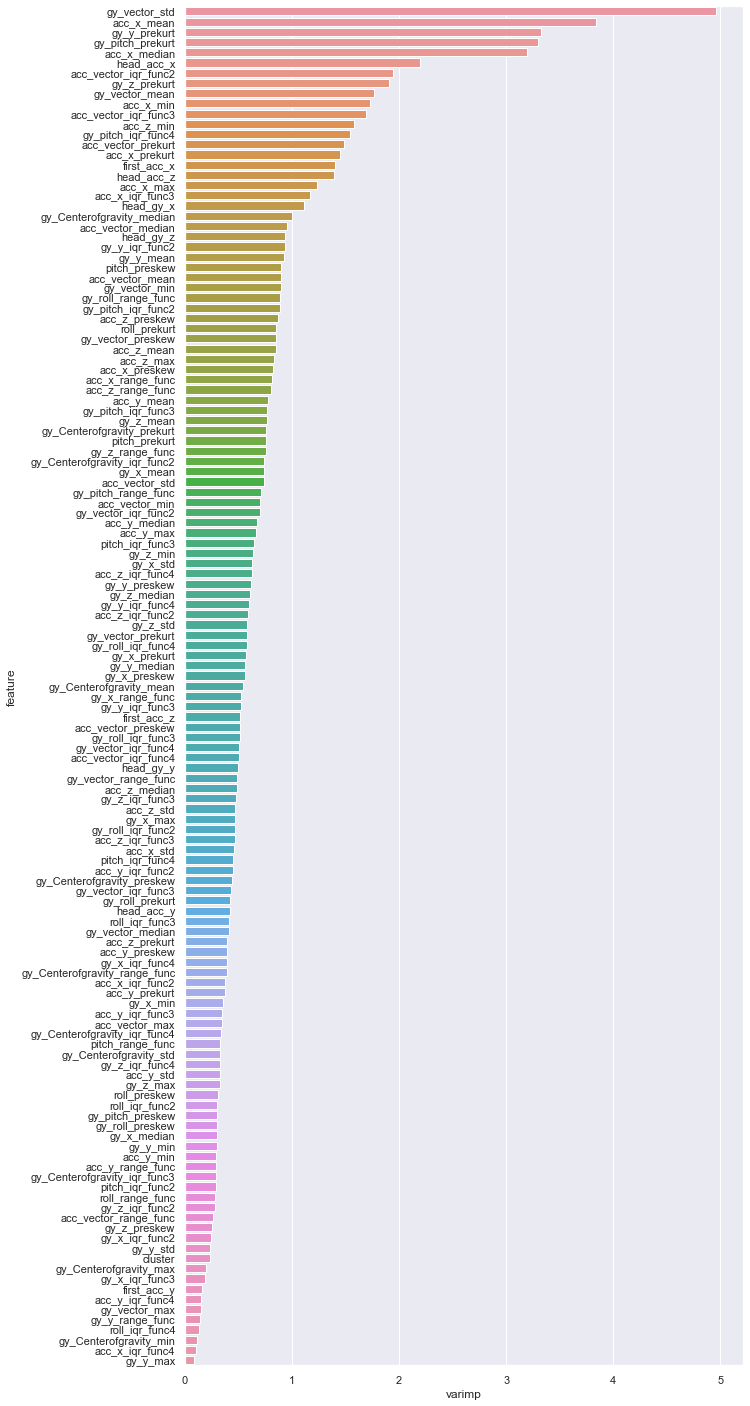

In [37]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,25)})
cat_feature_imp = pd.DataFrame([model_cb.feature_names_ , model_cb.feature_importances_]).T
cat_feature_imp.columns = ["feature","varimp"]
cat_feature_imp = cat_feature_imp.sort_values(by="varimp", ascending = False)
sns.barplot(y="feature", x="varimp",data = cat_feature_imp)
plt.show()

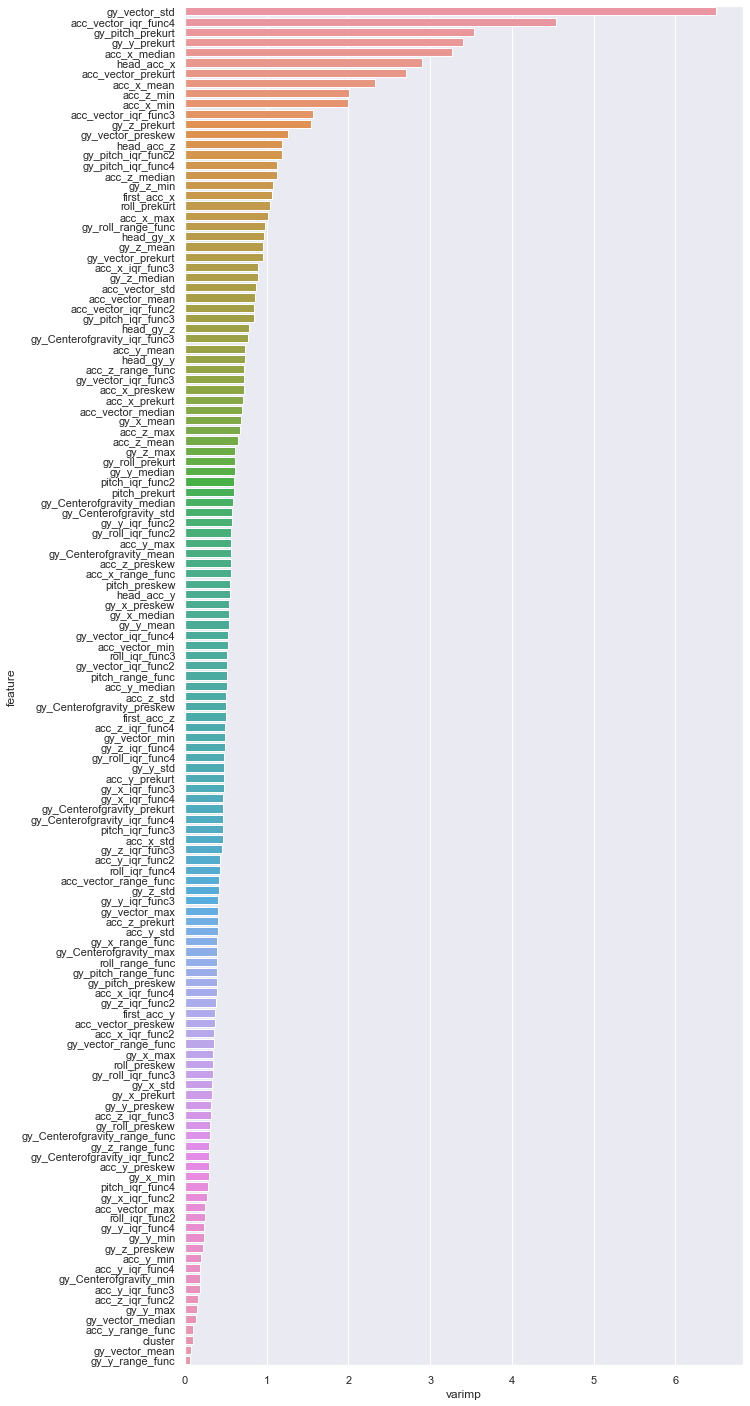

In [38]:
sns.set(rc={'figure.figsize':(10,25)})
cat_feature_imp = pd.DataFrame([model_cb_fin.feature_names_ , model_cb_fin.feature_importances_]).T
cat_feature_imp.columns = ["feature","varimp"]
cat_feature_imp = cat_feature_imp.sort_values(by="varimp", ascending = False)
sns.barplot(y="feature", x="varimp",data = cat_feature_imp)
plt.show()

depth별로

# randomforest

model_rf=RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0)
model_rf.fit(x1,y1_1)

print('train 정확도 : ',model_rf.score(x1,y1_1))
print('test 정확도 : ',model_rf.score(x2,y2_1))

In [39]:
print(x_label_split1.shape)
print(x_label_split2.shape)
print(y_label_split1.shape)
print(y_label_split2.shape)

(2482, 133)
(643, 133)
(2482,)
(643,)


GridSearch

BayesianOptimization

In [40]:
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

In [41]:
rf_parameter_bounds = {'n_estimators' : (50,300),
                      'max_depth' : (5,50),
                       'min_samples_leaf' : (4,10),
                      'min_samples_split' : (4,10),
                      }

def rf_bo(max_depth, n_estimators,min_samples_leaf,min_samples_split):
    rf_params = {
        'max_depth' : int(round(max_depth)),
        'n_estimators' : int(round(n_estimators)),      
        'min_samples_leaf' : int(round(min_samples_leaf)),
        'min_samples_split' : int(round(min_samples_split)),
    }
    
    model_BO_rf = RandomForestClassifier(**rf_params)

    model_BO_rf.fit(x_label_split1,y_label_split1)
    score = accuracy_score(y_label_split2, model_BO_rf.predict(x_label_split2))
    return score

In [42]:
BO_rf = BayesianOptimization(f = rf_bo, pbounds = rf_parameter_bounds,random_state = 0)

# Bayesian Optimization을 실행해보세요
BO_rf.maximize(init_points = 10, n_iter = 20)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7232   |  29.7     |  8.291    |  7.617    |  186.2    |
|  2        |  0.7278   |  24.06    |  7.875    |  6.626    |  272.9    |
|  3        |  0.7418   |  48.36    |  6.301    |  8.75     |  182.2    |
|  4        |  0.7201   |  30.56    |  9.554    |  4.426    |  71.78    |
|  5        |  0.6719   |  5.91     |  8.996    |  8.669    |  267.5    |
|  6        |  0.7232   |  49.04    |  8.795    |  6.769    |  245.1    |
|  7        |  0.7278   |  10.32    |  7.84     |  4.86     |  286.2    |
|  8        |  0.7356   |  28.48    |  6.488    |  5.587    |  243.6    |
|  9        |  0.7325   |  25.53    |  7.411    |  4.113    |  204.4    |
|  10       |  0.7294   |  32.54    |  7.702    |  9.662    |  220.5    |
|  11       |  0.7387   |  47.98    |  6.471    |  9.925    |  183.4    |
|  12       |  0.7403   |  49.42    | 

In [43]:

# 하이퍼파라미터의 결과값을 불러와 "max_params"라는 변수에 저장해보세요

max_params = BO_rf.max['params']

max_params['max_depth'] = int(max_params['max_depth'])
max_params['min_samples_leaf'] = int(max_params['min_samples_leaf'])
max_params['min_samples_split'] = int(max_params['min_samples_split'])
max_params['n_estimators'] = int(max_params['n_estimators'])
print(max_params)

# Bayesian Optimization의 결과를 "BO_tuend_rf"라는 변수에 저장해보세요

model_BO_rf_tuend = RandomForestClassifier(**max_params)

{'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 190}


In [44]:
model_BO_rf_tuend.fit(train_preprocess,train_labels['label'])

RandomForestClassifier(max_depth=50, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=190)

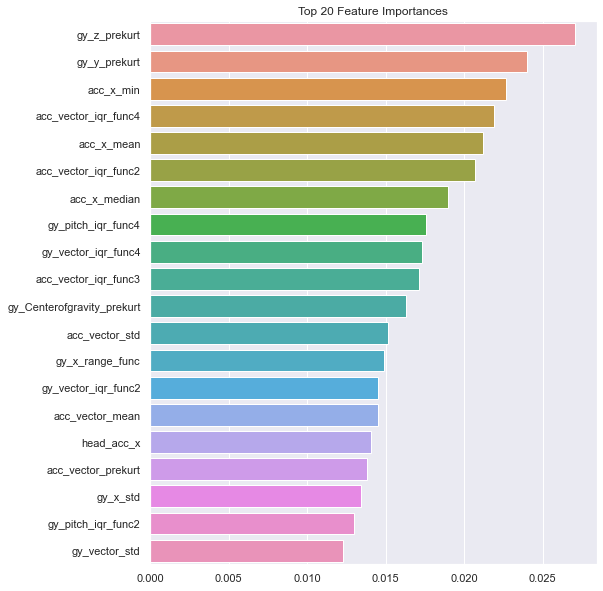

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = model_BO_rf_tuend.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = train_preprocess.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,10))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [46]:
model_BO_rf_tuend.fit(x_label_split1prediction2,y_label_split1)

RandomForestClassifier(max_depth=50, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=190)

In [47]:
print("train score : ",accuracy_score(model_BO_rf_tuend.predict(x_label_split1[ftr_top20.index]),y_label_split1))
print("test score : ",accuracy_score(model_BO_rf_tuend.predict(x_label_split2[ftr_top20.index]),y_label_split2))

train score :  0.9125705076551168
test score :  0.7433903576982893


In [49]:
BO_pred = model_BO_rf_tuend.predict(test_preprocess[ftr_top20.index])
BO_pred_hot = np_utils.to_categorical(BO_pred)
submission_BO_rf = sub.copy()
submission_BO_rf.iloc[:,1:]=BO_pred_hot
submission_BO_rf.to_csv('submission_BO_rf_220328.csv', index=False)

In [50]:
submission_BO_rf.to_csv('submission_BO_rf_220325.csv', index=False)

# CNN

In [51]:
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Conv1D, MaxPooling1D, Dropout, Flatten, Activation
from sklearn.model_selection import KFold, StratifiedKFold
from keras.utils import np_utils

In [52]:
y = train_labels['label']

In [53]:
print(train_arr_3d.shape)
print(test_arr_3d.shape)
print(y.shape)

(3125, 600, 13)
(782, 600, 13)
(3125,)


In [54]:
prediction=0
folds=10
repeats=2
epochsize=30
drop=0.5
skf = StratifiedKFold(n_splits=folds)
iter_num = 0

for k in range(repeats):
    for train_ind, test_ind in skf.split(train_arr_3d, y):
        
        iter_num += 1
        print(f"교차검증 : {iter_num}")
        
        model_cnn = Sequential()
        model_cnn.add(Conv1D (kernel_size=60, filters=256, strides=3, padding='valid',
                        kernel_initializer='he_uniform', input_shape=[600,13],
                        activation='relu'))
        model_cnn.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn.add(Conv1D(kernel_size=60, filters=128, activation='relu'))
        model_cnn.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn.add(Conv1D(kernel_size=60, filters=64, activation='relu'))
        model_cnn.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn.add(BatchNormalization())

        model_cnn.add(Dropout(drop))
        model_cnn.add(Flatten())
        model_cnn.add(Dense(1024, activation='relu'))
        model_cnn.add(BatchNormalization())

        model_cnn.add(Dropout(drop))
        model_cnn.add(Dense(1024, activation='relu'))
        model_cnn.add(BatchNormalization())

        model_cnn.add(Dropout(drop))
        model_cnn.add(Dense(1024, activation='relu'))
        model_cnn.add(BatchNormalization())


        model_cnn.add(Dropout(drop))
        model_cnn.add(Dense(61))
        model_cnn.add(Activation('softmax'))

        adam = tf.keras.optimizers.Adam(lr=0.0001)

        model_cnn.compile(loss='categorical_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy'])
        y_skf_hot = np_utils.to_categorical(y) # 3 -> [0,0,0,1,0, ..]
        
        model_cnn.fit(train_arr_3d[train_ind], y_skf_hot[train_ind], epochs=epochsize, batch_size=256,
                  validation_data=(train_arr_3d[test_ind], y_skf_hot[test_ind]))

        prediction += (model_cnn.predict(test_arr_3d)/(folds*repeats))

교차검증 : 1


C:\Users\lsj70\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
11/11 [==============================] - 30s 3s/step - loss: 5.4306 - accuracy: 0.0288 - val_loss: 12.1581 - val_accuracy: 0.0351
Epoch 2/30
11/11 [==============================] - 28s 3s/step - loss: 4.8662 - accuracy: 0.0967 - val_loss: 15.2238 - val_accuracy: 0.0479
Epoch 3/30
11/11 [==============================] - 27s 2s/step - loss: 4.3162 - accuracy: 0.2408 - val_loss: 19.6001 - val_accuracy: 0.0479
Epoch 4/30
11/11 [==============================] - 27s 2s/step - loss: 3.9712 - accuracy: 0.3247 - val_loss: 18.5855 - val_accuracy: 0.0671
Epoch 5/30
11/11 [==============================] - 27s 2s/step - loss: 3.7557 - accuracy: 0.3528 - val_loss: 16.6295 - val_accuracy: 0.0863
Epoch 6/30
11/11 [==============================] - 27s 2s/step - loss: 3.6436 - accuracy: 0.3755 - val_loss: 13.6845 - val_accuracy: 0.1246
Epoch 7/30
11/11 [==============================] - 27s 2s/step - loss: 3.4489 - accuracy: 0.3944 - val_loss: 11.8250 - val_accuracy: 0.1502
Epoch 8/30
11

11/11 [==============================] - 51s 5s/step - loss: 2.1540 - accuracy: 0.5388 - val_loss: 2.4693 - val_accuracy: 0.5048
Epoch 30/30
11/11 [==============================] - 52s 5s/step - loss: 2.1446 - accuracy: 0.5338 - val_loss: 2.4044 - val_accuracy: 0.5208
교차검증 : 3
Epoch 1/30
11/11 [==============================] - 55s 5s/step - loss: 5.5230 - accuracy: 0.0231 - val_loss: 11.4043 - val_accuracy: 0.0192
Epoch 2/30
11/11 [==============================] - 52s 5s/step - loss: 4.9919 - accuracy: 0.0590 - val_loss: 15.1967 - val_accuracy: 0.0415
Epoch 3/30
11/11 [==============================] - 51s 5s/step - loss: 4.5109 - accuracy: 0.1671 - val_loss: 17.3293 - val_accuracy: 0.0383
Epoch 4/30
11/11 [==============================] - 49s 4s/step - loss: 4.1549 - accuracy: 0.2696 - val_loss: 18.4534 - val_accuracy: 0.0383
Epoch 5/30
11/11 [==============================] - 51s 5s/step - loss: 3.8090 - accuracy: 0.3247 - val_loss: 17.2166 - val_accuracy: 0.0543
Epoch 6/30
11/11

11/11 [==============================] - 28s 3s/step - loss: 2.2934 - accuracy: 0.5190 - val_loss: 2.3205 - val_accuracy: 0.5321
Epoch 26/30
11/11 [==============================] - 29s 3s/step - loss: 2.2668 - accuracy: 0.5236 - val_loss: 5.0306 - val_accuracy: 0.3237
Epoch 27/30
11/11 [==============================] - 28s 3s/step - loss: 2.2572 - accuracy: 0.5219 - val_loss: 2.6075 - val_accuracy: 0.4551
Epoch 28/30
11/11 [==============================] - 28s 3s/step - loss: 2.2453 - accuracy: 0.5087 - val_loss: 2.2358 - val_accuracy: 0.5192
Epoch 29/30
11/11 [==============================] - 27s 2s/step - loss: 2.1938 - accuracy: 0.5254 - val_loss: 2.0211 - val_accuracy: 0.5417
Epoch 30/30
11/11 [==============================] - 27s 2s/step - loss: 2.1166 - accuracy: 0.5371 - val_loss: 2.0765 - val_accuracy: 0.5481
교차검증 : 7
Epoch 1/30
11/11 [==============================] - 30s 3s/step - loss: 5.4214 - accuracy: 0.0292 - val_loss: 10.8311 - val_accuracy: 0.0256
Epoch 2/30
11/11

KeyboardInterrupt: 

In [ ]:
submission_cnn = sub.copy()
submission_cnn.iloc[:,1:]=prediction
submission_cnn.to_csv('submission_cnn_220328.csv', index=False)

# 오버샘플링 CNN

In [ ]:
import random
from tqdm import tqdm_notebook

In [ ]:
train_labels['label'].value_counts()

In [ ]:
y_label = list(set(train_labels[train_labels['label']!=26]['label']))

In [ ]:
y_non_exer_non_id = []
for i in y_label:  
    y_non_exer_non_id += list(train_labels[train_labels['label'] == i]['id'])

In [ ]:
new_train = train.copy()
new_label = train_labels.copy()

for i in tqdm_notebook(y_non_exer_non_id, desc="tqdm example", mininterval=0.01):
    temp_x=train[train["id"]==i]
    temp_y=train_labels[train_labels["id"]==i]
    #num_count = train_labels['label'].value_counts()[train_labels[train_labels["id"]==0]['label']]
    for j in range(4):
        aa=random.randrange(1,600)
        temp2_x=temp_x.iloc[aa:600,:].append(temp_x.iloc[0:aa,:])
        temp2_x['time'] = range(600)
        temp2_x['id'] = [len(new_label)] * 600
        new_train=new_train.append(temp2_x)

        temp_y['id'] = len(new_label)
        
        new_label=new_label.append(temp_y)

In [ ]:
new_train_data = new_train.iloc[:,2:].copy()
new_train_s = []

for i in range(int(len(new_train_data)/600)):
    new_train_s.append(new_train_data[(i*600):((i+1)*600)])
    
new_train_arr = [np.array(i) for i in new_train_s]
new_train_arr_3d = np.array(new_train_arr)

In [ ]:
new_y=new_label['label']

In [ ]:
prediction2=0
folds=10
repeats=2
epochsize=30
drop=0.5
skf = StratifiedKFold(n_splits=folds)
iter_num = 0

for k in range(repeats):
    for train_ind, test_ind in tqdm_notebook(skf.split(new_train_arr_3d, new_y), desc="tqdm example", mininterval=0.01):
        
        iter_num += 1
        print(f"교차검증 : {iter_num}")
        
        model_cnn2 = Sequential()
        model_cnn2.add(Conv1D (kernel_size=60, filters=256, strides=3, padding='valid',
                        kernel_initializer='he_uniform', input_shape=[600,13],
                        activation='relu'))
        model_cnn2.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn2.add(Conv1D(kernel_size=60, filters=128, activation='relu'))
        model_cnn2.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn2.add(Conv1D(kernel_size=60, filters=64, activation='relu'))
        model_cnn2.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn2.add(BatchNormalization())

        model_cnn2.add(Dropout(drop))
        model_cnn2.add(Flatten())
        model_cnn2.add(Dense(1024, activation='relu'))
        model_cnn2.add(BatchNormalization())

        model_cnn2.add(Dropout(drop))
        model_cnn2.add(Dense(1024, activation='relu'))
        model_cnn2.add(BatchNormalization())

        model_cnn2.add(Dropout(drop))
        model_cnn2.add(Dense(1024, activation='relu'))
        model_cnn2.add(BatchNormalization())


        model_cnn2.add(Dropout(drop))
        model_cnn2.add(Dense(61))
        model_cnn2.add(Activation('softmax'))

        adam = tf.keras.optimizers.Adam(lr=0.0001)

        model_cnn2.compile(loss='categorical_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy'])
        new_y_skf_hot = np_utils.to_categorical(new_y) # 3 -> [0,0,0,1,0, ..]
        
        model_cnn2.fit(new_train_arr_3d[train_ind], new_y_skf_hot[train_ind], epochs=epochsize, batch_size=256,
                  validation_data=(new_train_arr_3d[test_ind], new_y_skf_hot[test_ind]))

        prediction2 += (model_cnn2.predict(test_arr_3d)/(folds*repeats))

In [ ]:
submission_cnn2 = sub.copy()
submission_cnn2.iloc[:,1:]=prediction2
submission_cnn2.to_csv('submission_overed_cnn_220328.csv', index=False)